# Group 5K fold

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_73474/3566521292.py:17: DtypeWarning: Columns (102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.7071
Precision    0.1533
Recall       0.4498
F1           0.2277
ROC AUC      0.6596
PR AUC       0.1470
dtype: float64

🔍 평균 Feature Importance (Top 15):
               Feature  Importance
57           Intensity    0.236737
15   mean_intensity_1h    0.119838
13     hungry_weighted    0.057979
12            Time_24h    0.054551
0         15m_G_Diff_5    0.040470
50      2_2.5h_pre_std    0.036418
44      1_1.5h_pre_std    0.034187
47      1.5_2h_pre_std    0.027030
1         15m_G_Diff_6    0.025320
45    1_1.5h_pre_slope    0.024274
2         15m_G_Diff_7    0.023953
53        Z_Previous_4    0.021543
29          Sleep_Diff    0.019442
27           TimeInBed    0.017898
62  G_minus_T_pre_1.5h    0.017619


# XGBoost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# 4. Model DataFrame
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# 5. GroupKFold Cross-validation
gkf = GroupKFold(n_splits=5)
threshold = 0.3

metrics = []
feature_importance_list = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # 6. SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 7. XGBoost 모델
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 8. 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance
    feature_importance_list.append(model.feature_importances_)

# 9. 평균 결과
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 10. 평균 Feature Importance
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_73474/1202726123.py:17: DtypeWarning: Columns (102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.8583
Precision    0.1993
Recall       0.1486
F1           0.1675
ROC AUC      0.6794
PR AUC       0.1711
dtype: float64

🔍 평균 Feature Importance (Top 15):
                         Feature  Importance
57                     Intensity    0.129400
50                2_2.5h_pre_std    0.059742
15             mean_intensity_1h    0.057090
47                1.5_2h_pre_std    0.052061
44                1_1.5h_pre_std    0.046661
13               hungry_weighted    0.040597
0                   15m_G_Diff_5    0.034462
45              1_1.5h_pre_slope    0.030242
48              1.5_2h_pre_slope    0.028051
2                   15m_G_Diff_7    0.027508
1                   15m_G_Diff_6    0.025870
54                          Z_HR    0.023255
40  Glucose_skew_hint_pre_1_2.5h    0.022683
12                      Time_24h    0.022507
3                   15m_G_Diff_8    0.022154


# LightGBM

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from tqdm import tqdm


# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]

# 모델 데이터 준비
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)
threshold = 0.3
metrics = []
feature_importance_list = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # 모델 파라미터
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.03,
        'num_leaves': 31,
        'max_depth': 6,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42,
        'n_jobs': -1
    }

    # 학습
    model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_val]
    )

    # 예측 및 평가
    y_proba = model.predict(X_val)
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importance(importance_type='gain'))

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 평균 Feature importance 출력
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_73474/1100358609.py:18: DtypeWarning: Columns (102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.8644
Precision    0.2045
Recall       0.1348
F1           0.1601
ROC AUC      0.6806
PR AUC       0.1723
dtype: float64

🔍 평균 Feature Importance (Top 15):
                         Feature    Importance
57                     Intensity  99842.504392
50                2_2.5h_pre_std  69673.263117
44                1_1.5h_pre_std  66748.451342
15             mean_intensity_1h  64191.210515
47                1.5_2h_pre_std  60060.842327
0                   15m_G_Diff_5  37847.735355
12                      Time_24h  31397.223295
1                   15m_G_Diff_6  26886.475042
5                  15m_G_Diff_10  26408.270222
13               hungry_weighted  21891.984752
2                   15m_G_Diff_7  21242.136936
3                   15m_G_Diff_8  20820.255449
40  Glucose_skew_hint_pre_1_2.5h  16428.222713
54                          Z_HR  12838.095375
51              2_2.5h_pre_slope  11404.6509

# Ensemble

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from collections import defaultdict


# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
    
]


# 결측치 제거
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)
threshold = 0.3

# 결과 저장용
metrics = []
feature_importances = defaultdict(list)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 개별 모델 정의
    rf = RandomForestClassifier(
        n_estimators=1000, max_depth=50, min_samples_split=50, min_samples_leaf=50,
        criterion='entropy', n_jobs=-1, random_state=42
    )
    xgb = XGBClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.05, use_label_encoder=False,
        eval_metric='logloss', n_jobs=-1, random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.05, n_jobs=-1, random_state=42
    )

    # VotingClassifier 정의
    ensemble = VotingClassifier(
        estimators=[("rf", rf), ("xgb", xgb), ("lgb", lgb)],
        voting='soft', n_jobs=-1
    )

    ensemble.fit(X_train, y_train)
    y_proba = ensemble.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # 성능 저장
    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # 각 모델의 feature importance 저장
    fitted_rf = ensemble.estimators_[0]
    fitted_xgb = ensemble.estimators_[1]
    fitted_lgb = ensemble.estimators_[2]

    feature_importances["rf"].append(fitted_rf.feature_importances_)
    feature_importances["xgb"].append(fitted_xgb.feature_importances_)
    feature_importances["lgb"].append(fitted_lgb.feature_importances_)

# 평균 성능 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 평균 feature importance
for model_name in feature_importances:
    avg_importance = np.mean(feature_importances[model_name], axis=0)
    top_features = pd.DataFrame({
        "Feature": X.columns,
        "Importance": avg_importance
    }).sort_values("Importance", ascending=False).head(15)
    
    print(f"\n🔍 Top 15 Feature Importance - {model_name.upper()}")
    print(top_features)



📂 Fold 1


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_73474/2736245487.py:20: DtypeWarning: Columns (102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")


[LightGBM] [Info] Number of positive: 25062, number of negative: 25062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14560
[LightGBM] [Info] Number of data points in the train set: 50124, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

# 10fold RF

# Target to continuous outcome - Glucose_1h later - post hoc (Threshold_1h_pre) - GE

# RandomForestRegressor

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre_84del.csv'
df = pd.read_csv(file_path)

# 2. Convert Time_24h to numeric hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60


# 3. Y값: 1시간 후 혈당
df['Glucose_1h_future'] = df.groupby('StudyID')['Glucose'].shift(-4)

# 3. X, y columns
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
]

y_column = "Glucose_1h_future"

X = df[X_columns]
y = df[y_column]

# 4. Drop rows with missing values in X or y
X = X.copy()
y = y.copy()
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# 5. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train with 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
rmse_list = []
r2_list = []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# 7. Results
print(f"MAE (mean): {np.mean(mae_list):.2f}")
print(f"RMSE (mean): {np.mean(rmse_list):.2f}")
print(f"R² (mean): {np.mean(r2_list):.2f}")


MAE (mean): 8.54
RMSE (mean): 12.27
R² (mean): 0.55


# XGRegressor

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre_84del.csv'
df = pd.read_csv(file_path)

# 2. Convert Time_24h to numeric hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 3. Y값: 1시간 후 혈당
df['Glucose_1h_future'] = df.groupby('StudyID')['Glucose'].shift(-4)

# 4. Define features and target
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
]

y_column = "Glucose_1h_future"

X = df[X_columns]
y = df[y_column]

# 5. Drop rows with missing values in X or y
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# 6. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. 5-fold CV with XGBRegressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, rmse_list, r2_list = [], [], []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae_list.append(mean_absolute_error(y_val, preds))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_list.append(r2_score(y_val, preds))

# 8. Results
print(f"MAE (mean): {np.mean(mae_list):.2f}")
print(f"RMSE (mean): {np.mean(rmse_list):.2f}")
print(f"R² (mean): {np.mean(r2_list):.2f}")


MAE (mean): 9.88
RMSE (mean): 13.77
R² (mean): 0.44


# VotingRegressor

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor

# 1. Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre_84del.csv'
df = pd.read_csv(file_path)

# 2. Convert Time_24h to numeric hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 3. Y값 생성
df['Glucose_1h_future'] = df.groupby('StudyID')['Glucose'].shift(-4)

# 4. Feature & Target 지정
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
]
y_column = "Glucose_1h_future"

X = df[X_columns]
y = df[y_column]

# 5. Drop rows with missing values
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# 6. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Define Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
voting = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb)])

# 8. 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, rmse_list, r2_list = [], [], []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    voting.fit(X_train, y_train)
    preds = voting.predict(X_val)

    mae_list.append(mean_absolute_error(y_val, preds))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_list.append(r2_score(y_val, preds))

# 9. 결과 출력
print(f"VotingRegressor MAE: {np.mean(mae_list):.2f}")
print(f"VotingRegressor RMSE: {np.mean(rmse_list):.2f}")
print(f"VotingRegressor R²: {np.mean(r2_list):.2f}")


VotingRegressor MAE: 9.11
VotingRegressor RMSE: 12.87
VotingRegressor R²: 0.51


# RF showed the best performance-> RF Gridsearch

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# 1. Load Data
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/filtered_thre_84del.csv'
df = pd.read_csv(file_path)

# 2. Convert Time
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 3. Target
df['Glucose_1h_future'] = df.groupby('StudyID')['Glucose'].shift(-4)

# 4. Feature Selection
X_columns = [  # 기존 X feature 목록
    "15m_G_Diff_5", "15m_G_Diff_6", "15m_G_Diff_7", "15m_G_Diff_8",
    "15m_G_Diff_9", "15m_G_Diff_10",
    "Z_Previous_5", "Z_Previous_6", "Z_Previous_7", "Z_Previous_8", "Z_Previous_9", "Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h", "Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h", "Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h", "Z_Previous_4", "Z_HR", "Z_Intensity",
    "HR", "Intensity", "1h_pre_Thre", "Glucose_pre_1h", "Glucose_pre_1.5h",
    "Glucose_pre_2h", "G_minus_T_pre_1.5h", "G_minus_T_pre_2h",
    "Threshold_pre_2h", "Threshold_pre_1.5h"
]
y_column = "Glucose_1h_future"

X = df[X_columns]
y = df[y_column]

# 5. Drop missing
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# 6. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Grid Search with 5-Fold CV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv,
                           scoring=scorer, n_jobs=-1, verbose=1)
grid_search.fit(X_scaled, y)

# 8. 결과 출력
best_model = grid_search.best_estimator_
preds = best_model.predict(X_scaled)
mae = mean_absolute_error(y, preds)
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds)

print("Best Parameters:", grid_search.best_params_)
print(f"Final Performance on All Data:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Final Performance on All Data:
MAE: 2.98
RMSE: 4.32
R²: 0.94


In [99]:
from sklearn.model_selection import KFold

# best_model: GridSearchCV.best_estimator_ 로부터 얻은 모델
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list, rmse_list, r2_list = [], [], []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_val)

    mae_list.append(mean_absolute_error(y_val, preds))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_list.append(r2_score(y_val, preds))

print(f"[5-Fold CV Performance]")
print(f"MAE (mean): {np.mean(mae_list):.2f}")
print(f"RMSE (mean): {np.mean(rmse_list):.2f}")
print(f"R² (mean): {np.mean(r2_list):.2f}")


[5-Fold CV 성능 평가]
MAE (mean): 8.51
RMSE (mean): 12.23
R² (mean): 0.56


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_73474/1940270375.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


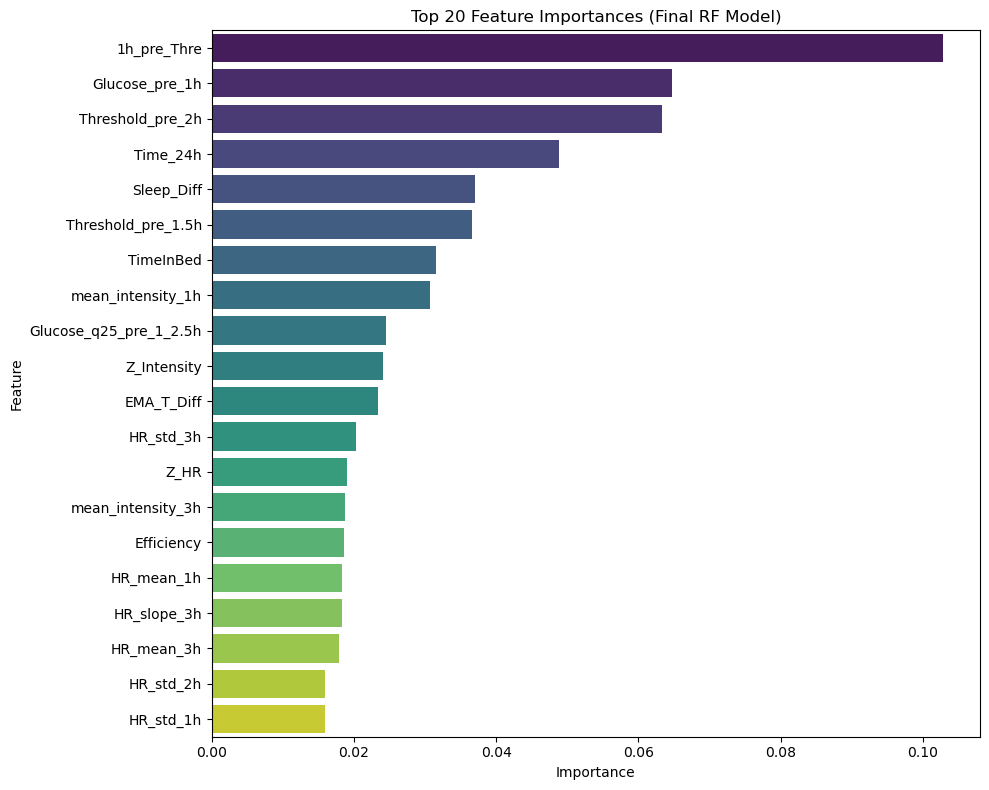

In [101]:
# 1. Best parameter 기반 최종 모델 구성
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 2. 전체 데이터로 한 번만 학습
final_model.fit(X_scaled, y)

# 3. Feature importance 추출 및 시각화
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Final RF Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [103]:
# Top 20

In [105]:
top20_features = [
    '1h_pre_Thre', 'Glucose_pre_1h', 'Threshold_pre_2h', 'Time_24h', 'Sleep_Diff',
    'Threshold_pre_1.5h', 'TimeInBed', 'mean_intensity_1h', 'Glucose_q25_pre_1_2.5h',
    'Z_Intensity', 'EMA_T_Diff', 'HR_std_3h', 'Z_HR', 'mean_intensity_3h',
    'Efficiency', 'HR_mean_1h', 'HR_slope_3h', 'HR_mean_3h',
    'HR_std_2h', 'HR_std_1h'
]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# X와 y 정의
X_top20 = df[top20_features]
y = df['Glucose_1h_future']

# 결측치 제거
mask = X_top20.notnull().all(axis=1) & y.notnull()
X_top20 = X_top20[mask]
y = y[mask]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top20)

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_list, rmse_list, r2_list = [], [], []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(
        n_estimators=200, max_depth=None,
        min_samples_split=2, min_samples_leaf=1,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae_list.append(mean_absolute_error(y_val, preds))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_list.append(r2_score(y_val, preds))

# 결과 출력
print(f"[Top 20 Feature 모델 성능]")
print(f"MAE: {np.mean(mae_list):.2f}")
print(f"RMSE: {np.mean(rmse_list):.2f}")
print(f"R²: {np.mean(r2_list):.2f}")


[Top 20 Feature 모델 성능]
MAE: 7.47
RMSE: 10.89
R²: 0.65


# Visualization

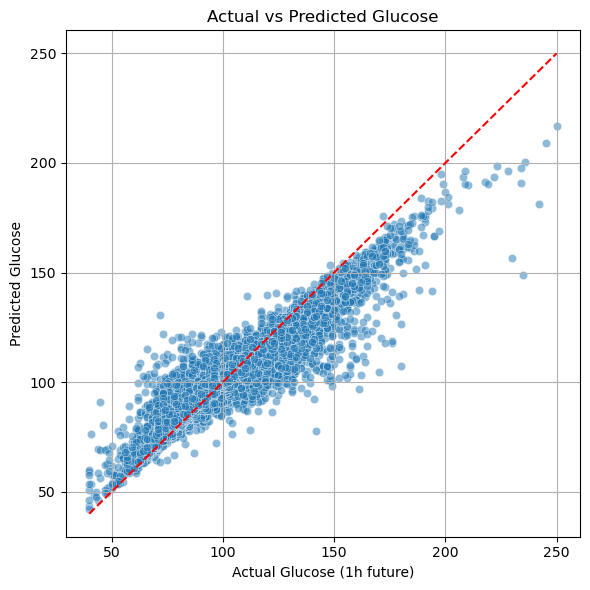

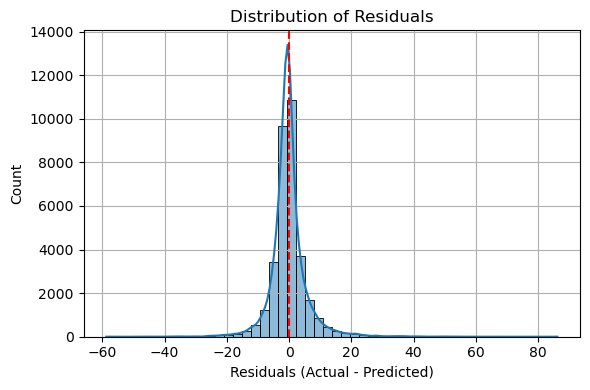

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 예측값 계산

y_pred = model.predict(X_scaled)  # ← 이 'model'은 20개 feature로 학습된 모델

# 1. Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 완벽한 예측 선
plt.xlabel("Actual Glucose (1h future)")
plt.ylabel("Predicted Glucose")
plt.title("Actual vs Predicted Glucose")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()
